In [1]:
import pandas as pd
import numpy as np

def excel_to_xyz_array(file_path):
    """
    将特定格式的Excel数据转换为N*3的numpy数组
    第一列（B3开始）为y坐标（南北方向），第一行（C2开始）为x坐标（东西方向）
    数据区域（C3开始）为z值
    
    参数：
        file_path: Excel文件路径
        
    返回：
        N*3的numpy数组，每行为[x, y, z]
    """
    # 读取Excel文件（不设置列名，保留原始数据）
    df = pd.read_excel(file_path, header=None)
    
    # 提取x坐标（东西方向）：第一行从C2开始（即索引位置[1,2:]）
    x_coords = df.iloc[1, 2:].values.astype(float)
    
    # 提取y坐标（南北方向）：第一列从B3开始（即索引位置[2:,1]）
    y_coords = df.iloc[2:, 1].values.astype(float)
    
    # 提取z值矩阵：数据区域从C3开始（即索引位置[2:, 2:]）
    z_matrix = df.iloc[2:, 2:].values.astype(float)
    
    # 创建网格坐标
    x_grid, y_grid = np.meshgrid(x_coords, y_coords)
    
    # 展平并组合成N*3数组
    xyz_array = np.vstack((
        x_grid.ravel(), 
        y_grid.ravel(), 
        z_matrix.ravel()
    )).T
    
    return xyz_array

# 使用示例
if __name__ == "__main__":
    # 替换为您的实际文件路径
    file_path = r"E:\2025\math_model\CUMCM_Trian\20250801\CUMCM2023B\附件.xlsx"
    result_array = excel_to_xyz_array(file_path)
    
    print(f"转换后的数组形状: {result_array.shape}")
    print("前5个点:")
    print(result_array[:5])

转换后的数组形状: (50451, 3)
前5个点:
[[0.000e+00 0.000e+00 2.440e+01]
 [2.000e-02 0.000e+00 2.412e+01]
 [4.000e-02 0.000e+00 2.385e+01]
 [6.000e-02 0.000e+00 2.359e+01]
 [8.000e-02 0.000e+00 2.334e+01]]


Hemisphere: 2957 planes fitted


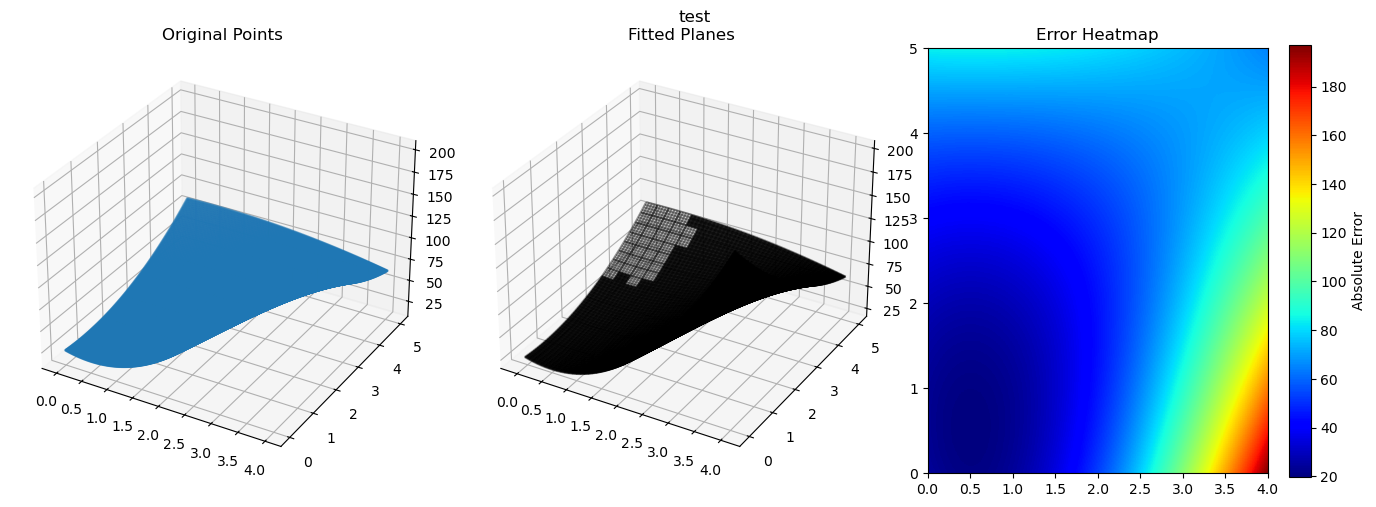

In [4]:
from ARPF import ARPF,Region,plot_result
tau = 5e-4
d_min = 1e-10
root = Region(-1, 5.5, -1, 5.5)
arpf = ARPF(mse_threshold=tau, min_region_size=d_min)
arpf.fit(xyz=result_array, root_region=root)
print(f"Hemisphere: {len(arpf.regions)} planes fitted")
plot_result(xyz=result_array,arpf=arpf, title="test")

ARPF 共拟合 9 个矩形平面


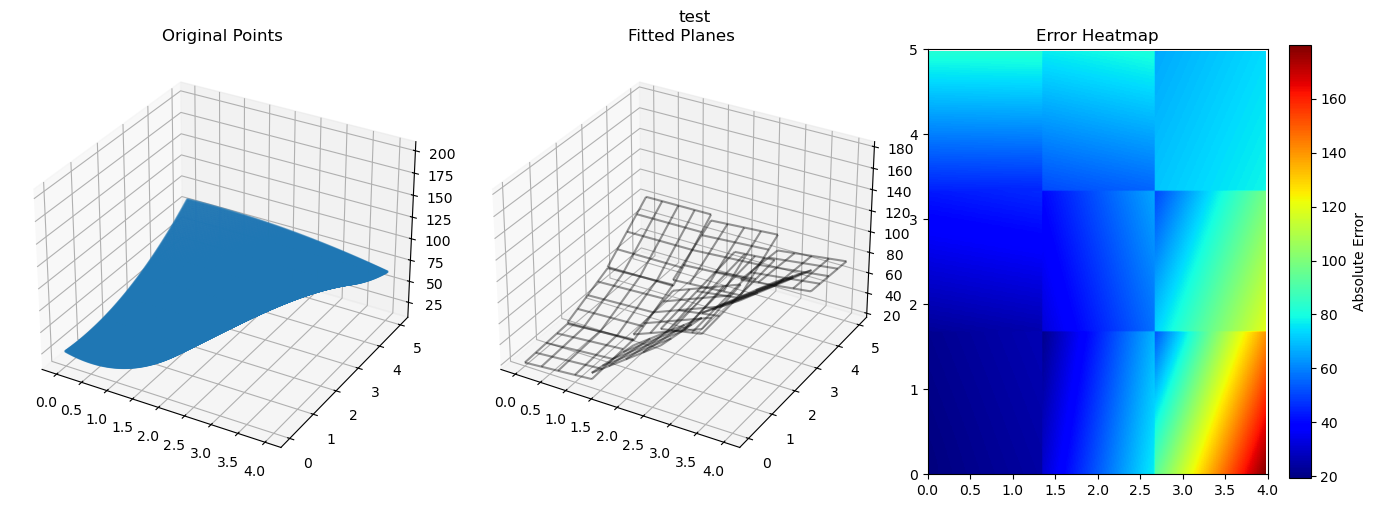

[[[0.         0.        ]
  [1.33333333 0.        ]
  [1.33333333 1.66666667]
  [0.         1.66666667]]

 [[0.         1.66666667]
  [1.33333333 1.66666667]
  [1.33333333 3.33333333]
  [0.         3.33333333]]

 [[0.         3.33333333]
  [1.33333333 3.33333333]
  [1.33333333 5.        ]
  [0.         5.        ]]]
[0.20667452 1.35609358 0.62714546]


KeyboardInterrupt: 

In [19]:
# ================== Task4_region_lines.py ==================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 1. 复用 ARPF.py 中的 Region / Plane / ARPF
from ARPF import ARPF, Region, plot_result  # 后两个仅用于演示

# 2. 将 Task3 的布线算法封装为对单个 Region 的函数 -----------------
def plan_lines_deep_to_shallow(
	theta_deg=120,  # 换开角 θ
	alpha_deg=0.20667452,  # 坡度 α
	eta=0.10,  # 期望重叠率 η  (10 %–20 % 之间取值)
	D_center=20.68,  # 海域中心深度  (m)
	L_ew_nm=5/3,  # 东-西总跨度 (nmi)
):
	"""
	由西(深)向东(潜)逐条布线，返回每条测线的中心横坐标 x 和水深 D。
	x=0 定义在西侧边界，正向指向东侧。
	"""
	# 常量与单位换算
	nmi2m = 1852.0
	L_x = L_ew_nm * nmi2m  # 东-西长度 (m)
	theta = np.radians(theta_deg)
	alpha = np.radians(alpha_deg)

	# —— 1. 计算西端(最深)水深 D0 ——
	half_len = L_x / 2  # 西边界到中心距离
	D0 = D_center + half_len * np.tan(alpha)  # 最深处 (x=0) 水深
	# print(f"中心水深 D_center = {D_center:.2f} m")
	# print(f"西端水深 D0 = {D0:.2f} m")

	# —— 2. 第一条测线 ——
	d1 = D0 * np.tan(theta / 2)  # 与边界距离
	D1 = D0 - d1 * np.tan(alpha)  # 第一条测线中心水深
	W1_left = D1 * np.sin(theta / 2) / np.cos(theta / 2 + alpha)
	W1_right = D1 * np.sin(theta / 2) / np.cos(theta / 2 - alpha)
	W1 = W1_left + W1_right  # 第一条测线宽度
	
	x_list = [d1]  # 第 1 条测线横坐标
	D_list = [D1]  # 第 1 条测线水深
	Wl_list = [W1_left]  # 第 1 条测线左侧宽度
	Wr_list = [W1_right]  # 第 1 条测线右侧宽度
	W_list = [W1]  # 第 1 条测线宽度

	# —— 3. 迭代生成后续测线 ——
	while True:
		Dk = D_list[-1]  # 当前(第 k 条)水深
		Wk = W_list[-1]  # 当前(第 k 条)测线宽度
		# 间距公式  (题设给出)
		# delta = (
		#     (1 - eta)
		#     * Dk
		#     * (1 + np.cos(theta / 2 + alpha) * (1 / np.cos(theta / 2 - alpha)))
		# ) / (1 - np.tan(alpha))
		delta = Wk*(1-eta)*np.cos(alpha)/(1+np.sin(alpha)*np.sin(theta/2)/np.cos(theta/2+alpha)*(1-eta))
		next_x = x_list[-1] + delta

		# 到达或超出东侧边界即停止
		if next_x >= L_x:
			break

		# 下一测线水深
		D_next = D0 - next_x * np.tan(alpha)
		
		# 下一测线宽度
		W_next_left = D_next * np.sin(theta / 2) / np.cos(theta / 2 + alpha)
		W_next_right = D_next * np.sin(theta / 2) / np.cos(theta / 2 - alpha)
		W_next = W_next_left + W_next_right
		
		x_list.append(next_x)
		D_list.append(D_next)
		Wl_list.append(W_next_left)
		Wr_list.append(W_next_right)
		W_list.append(W_next)
		
	# ---------- 计算左右边界及重叠 ----------
	x_left  = np.array(x_list) - np.array(Wl_list)
	x_right = np.array(x_list) + np.array(Wl_list)

	overlap_start = np.maximum(x_left[:-1],  x_left[1:])
	overlap_end   = np.minimum(x_right[:-1], x_right[1:])
	overlap_w     = np.maximum(0, overlap_end - overlap_start)  # 负值即无重叠
	overlap_eta   = np.divide(overlap_w, W_list[:-1],
							  out=np.zeros_like(overlap_w),
							  where=W_list[:-1]!=0)
	# —— 4. 汇总为 DataFrame ——
	df = pd.DataFrame(
		{
			"line_no": np.arange(1, len(x_list) + 1),
			"x_center(m)": np.round(x_list, 2),
			"depth(m)": np.round(D_list, 2),
			"W_left(m)": np.round(Wl_list, 2),
			"W_right(m)": np.round(Wr_list, 2),
			"W_total(m)": np.round(W_list, 2),
			"x_left(m)": np.round(x_left, 2),
			"x_right(m)": np.round(x_right, 2)
		}
	)

	# 把与前一条的重叠信息另存一张表，便于绘图
	df_overlap = pd.DataFrame({
		"pair_k/k+1":      df["line_no"][:-1],
		"ov_start(m)":     np.round(overlap_start, 2),
		"ov_end(m)":       np.round(overlap_end,   2),
		"ov_width(m)":     np.round(overlap_w,     2),
		"ov_ratio(k)":     np.round(overlap_eta*100, 2)   # 与第 k 条条带相比的百分比
	})

	return df, df_overlap

def plan_contour_lines_for_region(reg: Region, plane,vert):
        '''
        reg: Region 对象，表示拟合的矩形区域
        plane: Plane 对象，表示拟合的平面(方程)
        vert:对应的四个点的顶点集
		'''
        a,b,c = plane.a, plane.b, plane.c
        denom = np.sqrt(a**2 + b**2 + c**2)
    # 防止除以 0（理论上不会，因为平面方程至少有一个系数非零）
        denom = max(denom, 1e-12)
        cos_theta = abs(c) / denom
        # 防止数值越界导致 arccos 报错
        cos_theta = np.clip(cos_theta, 0.0, 1.0)
        alpha = (np.arccos(cos_theta))#弧度
        # v_l = np.array([b,-a,0])#测线方向向量
        # v_l_T = np.array([a,b,0])/np.sqrt(a**2+b**2)#垂直测线方向
        # X1,X2,X3,X4 = vert[0],vert[1],vert[2],vert[3]
        # Proj1,Proj2,Proj3,Proj4 = np.dot(X1,v_l_T),np.dot(X2,v_l_T),np.dot(X3,v_l_T),np.dot(X4,v_l_T)
        # d = max(Proj1,Proj2,Proj3,Proj4) - min(Proj1,Proj2,Proj3,Proj4)#东西方向距离
        X1,X2,X3,X4 = vert[0][0],vert[1][0],vert[2][0],vert[3][0]
        Y1,Y2,Y3,Y4 = vert[0][1],vert[1][1],vert[2][1],vert[3][1]
        X_min,X_max = min(X1,X2,X3,X4),max(X1,X2,X3,X4)
        Y_min,Y_max = min(Y1,Y2,Y3,Y4),max(Y1,Y2,Y3,Y4)
        d_center = a*(X_max+X_min)/2+b*(Y_max+Y_min)/2+c#中心距离
        df,df_overlap = plan_lines_deep_to_shallow(alpha_deg=np.degrees(alpha),D_center=d_center,L_ew_nm=np.sqrt((X_max-X_min)**2+(Y_max-Y_min)**2))
        del df_overlap
        return df



# 3. 读取 Excel → xyz ----------------------------------------------------------
def excel_to_xyz_array(file_path):
    df = pd.read_excel(file_path, header=None)
    x_coords = df.iloc[1, 2:].values.astype(float)
    y_coords = df.iloc[2:, 1].values.astype(float)
    z_matrix = df.iloc[2:, 2:].values.astype(float)
    x_grid, y_grid = np.meshgrid(x_coords, y_coords)
    return np.vstack((x_grid.ravel(), y_grid.ravel(), z_matrix.ravel())).T


# 4. 主流程 --------------------------------------------------------------------
if __name__ == '__main__':
    # 4.1 读数据
    file_path = r"E:\2025\math_model\CUMCM_Trian\20250801\CUMCM2023B\附件.xlsx"  # 修改为你的路径
    xyz = excel_to_xyz_array(file_path)

    # 4.2 ARPF 拟合
    tau = 5e-4
    d_min = 2
    root = Region(xyz[:, 0].min(), xyz[:, 0].max(),
                  xyz[:, 1].min(), xyz[:, 1].max())
    arpf = ARPF(mse_threshold=tau, min_region_size=d_min)
    arpf.fit(xyz, root)
    print(f"ARPF 共拟合 {len(arpf.regions)} 个矩形平面")
    plot_result(xyz=xyz,arpf=arpf, title="test")
    verts = arpf.get_region_vertices()
    angel = arpf.get_plane_tilt_angles()

    print(verts[:3])
    print(angel[:3])
    # 4.3 对每个 region 布线
    all_lines = []
    for idx, (reg, plane) in enumerate(zip(arpf.regions, arpf.planes)):
        # 可任选 x 或 y 方向布线；此处以 x 方向为例
        vert = verts[idx]
        z = plane.a*vert[:,0]+plane.b*vert[:,1]+plane.c
        vert = np.column_stack((vert,z))
        df_x = plan_contour_lines_for_region(reg, plane,vert)
        df_x['region_id'] = idx
        all_lines.append(df_x)
        break

    # 4.4 汇总结果
    lines_df = pd.concat(all_lines, ignore_index=True)
    lines_df.to_excel("Task4_all_region_lines.xlsx", index=False)
    print("结果已导出至 Task4_all_region_lines.xlsx")

    # 4.5 可选：预览前 3 个 region 的布线数量
    print(lines_df.groupby('region_id').size().head(3))